# Introduction

## Tensor and tensor network

Tensor is a higher-dimensional generalization of the matrix, which has two indices such as $M_{ij}$.
For example, a four-dimensional tensor can be obtained by the tensor product of two matrices $\left(A\otimes B\right)_{ij}=C_{ij}=C_{k\cdot d_{l}+l, m\cdot d_{n}+n}=A_{km}\cdot B_{ln}\equiv T_{mn}^{kl}$, where $d_{l, n}$ are the dimensions of the corresponding indices.
Each index of a tensor is called a *bond*.
Any element in a rank-$D$ tensor $T_{n_{0}, n_{1}, \cdots, n_{D-1}}$ can be mapped to a one-dimensional vector $v(p)$, which is the actual physical storage in a computer's memory.
Generally there are two ways to do this.

- *Row-major*. $p=\sum_{k=0}^{D-1}n_{k}\cdot\left(\prod_{l=k+1}^{D-1}d_{l}\right)$. The elements along the last index are contiguous. It is implemented in `numpy` as default.
-  *Column-major*. $p=\sum_{k=0}^{D-1}n_{k}\cdot\left(\prod_{l=0}^{k-1}d_{l}\right)$. The elements along the first index are contiguous. It is implement in Fortran and `Eigen::Tensor<>` (C++) as default.

Two different tensors can be contracted if two they share a same dimension.
It is the generalization of the matrix production like $C_{ij}=\sum_{k}A_{ik}B_{kj}$.
Graphically, we use a connected link to denote the connection of two bonds.
Tensors with some connected and unconnected bonds can form a *tensor network* (TN).

## Matrix product state and matrix product operator

Firstly I should point out the so-called  and matrix product operator (MPO) are actually comprised of tensors rather than matrices.
This is a historical issue.
A one-dimensional (1D) quantum state can be written as a matrix product state (MPS):
$$|\psi\rangle=\sum_{\{j\}}\left(A^{j_{0}}\cdots A^{j_{N-1}}\right)|j_{0}\cdots j_{N-1}\rangle.$$
$A$ has already been chosen to be *left-canonical*, namley $\sum_{j}A^{j\dagger}A^{j}=1$.
The basic idea of MPO is to introduce virtual bonds to decouple the operation of a many-body operator with finite range interactions into the production of local onsite tensors.

A matrix product operator (MPO) looks like
\begin{equation}
H=W^{j_{0}^{\prime}j_{0}}_{1, \gamma_{0}}W^{j_{1}^{\prime}j_{1}}_{\gamma_{0}\gamma_{1}}\cdots W^{j_{N-1}^{    \prime}j_{N-1}}_{\gamma_{N-2},1}|\{j^{\prime}\}\rangle\langle\{j\}|.
\end{equation}
One of the simplest physical TN is to compute the expection vaule of a MPO in terms a MPS like $\langle\psi|H|\psi\rangle$, which can be expressed

<p>
    <center><img src='images/tn_mpo_expection_value.png' width='300' alt>
    <em>TN for $\langle\psi|H|\psi\rangle$.</em></center>
</p>


# How to practically contract a TN

## An example

Here we consider a TN $\langle\psi|H|\psi\rangle$ as an example, in which $H$ is chosen to be the XYZ-model
\begin{equation}
H=\sum_{j=0}^{N-2}\left(J_{x}\sigma_{j}^{x}\sigma_{j+1}^{x}+J_{y}\sigma_{j}^{y}\sigma_{j+1}^{y}+J_{z}\sigma_{j}^{z}\sigma_{j+1}^{z}\right)+h\sum_{j=0}^{N-1}\sigma_{j}^{z}.
\end{equation}
Written into a MPO
\begin{equation}
    W_{n}=
    \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 \\ 
        J_{x}\sigma^{x} & 0 & 0 & 0 & 0 \\ 
        J_{y}\sigma^{y} & 0 & 0 & 0 & 0 \\ 
        J_{z}\sigma^{z} & 0 & 0 & 0 & 0 \\ 
        h\sigma^{z} & \sigma^{x} & \sigma^{y} & \sigma^{z} & 1 \\ 
    \end{pmatrix}.
    \label{eq:bulk_mpo}
\end{equation}

we have several methods to contract this TN:
- *Naive method (NM)*.
By a naive way, we can paste all the tensors piece by piece utilizing `tensordot`.
On site $j$, we can paste the upper MPS, MPO and lower mps into a rank-6 onsite tensor.
Then paste it to the environment tensor, which has three virtual bonds.


- *Optimized `einsum` (OE)*.
By utilizing [`opt_einsum`](https://joss.theoj.org/papers/10.21105/joss.00753), we can speed up the contraction dramatically, which could find the optimal contraction order automatically.
At each site $j$, we can contract the environment, upper MPS, MPO and lower MPS at the same time.
Moreover, it supports CUDA through [`CuPy`](https://cupy.chainer.org). 


- *Optimized `einsum` as a whole graph*. Instead of site by site, we can pass all the tensors and contracting information to `opt_einsum`, which can handle the whole TN and find out the optimal contracting path.
This method will be particularly useful to contracting a two-dimensional TN.

## Numerical results

Platform: `Intel(R) Xeon(R) CPU E5-2640`, `NVIDIA Tesla P100`, `CUDA 9.2.88`.
The XYZ-Hamiltonian is chosen as $J_{x}=J_{y}=1.0, J_{z}=h=0.5$.
The MPS is generated randomly.
To reduce the time fluctuations, in each individual test we repeat the contraction for $10$ times.

We found that:
- By utilizing `opt_einsum` in stead of the naive `tensordot`, the contraction can be dramatically speeded up $400$ times as much as possible especially with large bond dimension $\chi$.
With relatively small $\chi$, CUDA-OE is even slower than OE, while not too much.
- `CUDA` can further speed up about as many as $10^{3}$ times.
It reaches the threshold at about $\chi\simeq 250$, below which we think that the cores in GPU are not fully implemented.
Overall, if we use `opt_einsum` combined with `CUDA`, we can speed up the tensor contraction as many as $10^{5}$ times in comparison with the naive `tensordot`.

<p>
    <center><img src='images/time_nm_oe.pdf' width='400' alt>
    <em>Time for contracting the TN with $L=32$ in terms of NM, OE and CUDA-OE.</em></center>
</p>

<p>
    <center><img src='images/time_cuda.pdf' width='400' alt>
    <em>Time for contracting the TN with $L=128$ in terms OE and CUDA-OE.</em></center>
</p>

In [ ]:
import numpy as np
import torch
import timeit
import opt_einsum as oe
from scipy.stats import unitary_group as ug

In [ ]:
DIM_PHYS = 2


class FiniteOpenMPS:
    # class contructor
    # class members: numsite, dim_bond, dims, tensors
    def __init__ (self, num_site, chi):
        self.num_site = num_site
        self.dim_bond = chi
        # determine the bond dimension of the (num_site+1) bonds
        dims = []
        # from left to center
        d = 1
        dims.append (d)
        d = d*DIM_PHYS
        for l in range (num_site // 2):
            if d < chi:
                dims.append (d)
                d = d*DIM_PHYS
            else:
                dims.append (chi)
        # from right to center
        d = 1
        dims.append (d)
        d = d*DIM_PHYS
        for l in range (num_site-2, (num_site // 2)-1, -1):
            if d < chi:
                dims.insert ((num_site // 2)+1, d)
                d = d*DIM_PHYS
            else:
                dims.insert ((num_site // 2)+1, chi)
        self.dims = dims
        self.tensors = []
    # generate a random right-canonical MPS
    def RandomRightCanonical (self):
        for site in range (self.num_site):
            dim_alpha, dim_beta = self.dims[site], self.dims[site+1]
            u_mat = ug.rvs (DIM_PHYS*dim_beta)[:dim_alpha]
            right_tensor = u_mat.reshape (dim_alpha, DIM_PHYS, dim_beta)
            # permute the physical bond to the front
            self.tensors.append (np.transpose (right_tensor, (1, 0, 2)))
    def RandomRightCanonicalCuPy (self):
        for site in range (self.num_site):
            dim_alpha, dim_beta = self.dims[site], self.dims[site+1]
            u_mat = ug.rvs (DIM_PHYS*dim_beta)[:dim_alpha]
            right_tensor = cp.asarray (u_mat.reshape (dim_alpha, DIM_PHYS, dim_beta))
            # permute the physical bond to the front
            self.tensors.append (cp.transpose (right_tensor, (1, 0, 2)))
    # write the MPS to the file
    def WriteToFile (self, file_name):
        fr = open (file_name, 'wb')
        pickle.dump (self.tensors, fr)
        fr.close ()     
    # read from the file
    def ReadFromFile (self, file_name):
        tensor_list = pickle.load (open (file_name, 'rb'))
        if self.num_site != len (tensor_list):
            print ('error: mismatched size of the loaded MPS!')
        else:
            self.tensors = tensor_list 
        
class XYZHamiltonianMPO:
    def __init__ (self, num_site, Jx, Jy, Jz, h):
        self.num_site = num_site
        self.Jx = Jx
        self.Jy = Jy
        self.Jz = Jz
        self.h = h
        self.tensors = []
        # Pauli matrices
        Id = np.matrix ([[1.0, 0.0], [0.0, 1.0]])
        Sx = np.matrix ([[0.0, 1.0], [1.0, 0.0]])
        Sy = np.matrix ([[0.0, -1.j], [1.j, 0.0]])
        Sz = np.matrix ([[1.0, 0.0], [0.0, -1.0]])
        # mpo frame
        dim_mpo = 5
        mpo_frame = np.zeros ((dim_mpo, dim_mpo), dtype=float)
        w_bulk = np.zeros ((dim_mpo*DIM_PHYS, dim_mpo*DIM_PHYS), dtype=complex)
        ver_list = [Id, self.Jx*Sx, self.Jy*Sy, self.Jz*Sz]
        hor_list = [Sx, Sy, Sz, Id]
        # set the onsite term
        mpo_frame[4, 0] = 1.0
        w_bulk += np.kron (mpo_frame, self.h*Sz)
        # set the nearest interaction terms
        for i in range (dim_mpo-1):
            mpo_frame.fill (0.0)
            mpo_frame[i, 0] = 1.0
            w_bulk += np.kron (mpo_frame, ver_list[i])
        for i in range (dim_mpo-1):
            mpo_frame.fill (0.0)
            mpo_frame[dim_mpo-1, i+1] = 1.0
            w_bulk += np.kron (mpo_frame, hor_list[i])
        # boundary vectors   
        bdv_left = np.array ([[0.0, 0.0, 0.0, 0.0, 1.0]])
        bdv_right = np.transpose (np.array ([[1.0, 0.0, 0.0, 0.0, 0.0]]))
        w_head = np.kron (bdv_left, Id) @ w_bulk
        w_tail = w_bulk @ np.kron (bdv_right, Id)
        # reshape and permute to mpo tensors
        mpo_bulk = np.transpose (np.array (w_bulk).reshape (dim_mpo, DIM_PHYS, dim_mpo, DIM_PHYS),
                                 (1, 3, 0, 2)).copy ()
        mpo_head = np.transpose (np.array (w_head).reshape (1, DIM_PHYS, dim_mpo, DIM_PHYS),
                                 (1, 3, 0, 2)).copy ()
        mpo_tail = np.transpose (np.array (w_tail).reshape (dim_mpo, DIM_PHYS, 1, DIM_PHYS),
                                 (1, 3, 0, 2)).copy ()
        self.tensors.append (mpo_head)
        for i in range (self.num_site-2):
            self.tensors.append (mpo_bulk)
        self.tensors.append (mpo_tail)
    # simple method
    def ExpectionValueSimple (self, mps):
        temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
        for site in range (self.num_site):
            # site_tensor: * stands for a MPS; O stands for a MPO
            # --*--
            #   |
            # --O--
            #   |
            # --*--
            site_tensor = np.tensordot (np.conjugate (mps.tensors[site]), self.tensors[site],
                                        axes=((0), (0)))
            site_tensor = np.tensordot (site_tensor, mps.tensors[site],
                                        axes=((2), (0)))
            temp_tensor = np.tensordot (temp_tensor, site_tensor,
                                        axes=((1, 3, 5), (0, 2, 4)))
            temp_tensor = np.transpose (temp_tensor, (0, 3, 1, 4, 2, 5))
        return temp_tensor.reshape (1)[0]
    # opt_einsum
    def ExpectionValueOE (self, mps):
        temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
        for site in range (self.num_site):
            # contract temp_tensor, mps and mpo
            # a----d,d--*--h  
            #           |g,g
            # b----e,e--*--j
            #           |i,i
            # c----f,f--*--k
            temp_tensor = oe.contract ('abcdef,gdh,giej,ifk',
                                       temp_tensor,
                                       np.conjugate (mps.tensors[site]),
                                       self.tensors[site],
                                       mps.tensors[site],
                                       memory_limit=-1)
        return temp_tensor.reshape (1)[0]
    # opt_sum+cupy
    def ExpectionValueTorchOE (self, mps):
        temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
        for site in range (self.num_site):
            # contract temp_tensor, mps and mpo
            # a----d,d--*--h  
            #           |g,g
            # b----e,e--*--j
            #           |i,i
            # c----f,f--*--k
            temp_tensor = oe.contract ('abcdef,gdh,giej,ifk',
                                       temp_tensor,
                                       np.conjugate (mps.tensors[site]),
                                       self.tensors[site],
                                       mps.tensors[site],
                                       memory_limit=-1, backend='torch')
        return temp_tensor.reshape (1)[0]
    # opt_sum+cupy
    def ExpectionValueCupyOE (self, mps):
        temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
        for site in range (self.num_site):
            # contract temp_tensor, mps and mpo
            # a----d,d--*--h  
            #           |g,g
            # b----e,e--*--j
            #           |i,i
            # c----f,f--*--k
            temp_tensor = oe.contract ('abcdef,gdh,giej,ifk',
                                       temp_tensor,
                                       np.conjugate (mps.tensors[site]),
                                       self.tensors[site],
                                       mps.tensors[site],
                                       memory_limit=-1, backend='cupy')
        return temp_tensor.reshape (1)[0]
    # opt_sum graph
    def ExpectionValueGraphOE (self, mps):
        einsum_str = ''
        # build the first tensor block, which consists of three tensors
        # --*--
        #   |
        # --*--
        #   |
        # --*--
        site = 0
        # upper MPS tensor
        u0, u1, u2 = (oe.get_symbol (i) for i in (site+0, site+1, site+2))
        # middle MPO tensor
        m0, m1, m2, m3 = (oe.get_symbol (i) for i in (site+0, site+3, site+4, site+5))
        # lower MPS tensor
        l0, l1, l2 = (oe.get_symbol (i) for i in (site+3, site+6, site+7))
        einsum_str += '{}{}{},{}{}{}{},{}{}{},'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)
        # build the rest tensor blocks, consecutively to be be contracted to the first one
        # --*--
        #   |
        # --*--
        #   |
        # --*--
        for site in range (1, self.num_site):
            bond = site*8
            u0, u1, u2 = (oe.get_symbol (i) for i in (bond+0, (site-1)*8+2, bond+2))
            m0, m1, m2, m3 = (oe.get_symbol (i) for i in (bond+0, bond+3, (site-1)*8+5, bond+5))
            l0, l1, l2 = (oe.get_symbol (i) for i in (bond+3, (site-1)*8+7, bond+7))
            if site != self.num_site-1:
                einsum_str += '{}{}{},{}{}{}{},{}{}{},'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)
            else:
                einsum_str += '{}{}{},{}{}{}{},{}{}{}'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)
        tensor_args = []
        for site in range (self.num_site):
            tensor_args.append (np.conjugate (mps.tensors[site]))
            tensor_args.append (self.tensors[site])
            tensor_args.append (mps.tensors[site])
        res = oe.contract (einsum_str, *tensor_args, optimize='greedy', memory_limit=-1)
        return res.reshape (1)[0]

In [ ]:
# lattice parameters
num_site = 64
Jx = 1.0
Jy = 1.0
Jz = 0.5
h = 0.5

chi = 16

ham_mpo = XYZHamiltonianMPO (num_site, Jx, Jy, Jz, h)
mps = FiniteOpenMPS (num_site, chi)
mps.RandomRightCanonical ()

In [ ]:
repeat = 10

start = timeit.default_timer ()
for i in range (repeat):
    # print (i)
    res = ham_mpo.ExpectionValueSimple (mps)
stop = timeit.default_timer ()
print (res, (stop - start)*1000, 'ms')

start = timeit.default_timer ()
for i in range (repeat):
    res = ham_mpo.ExpectionValueOE (mps)
stop = timeit.default_timer ()
print (res, (stop - start)*1000, 'ms')

start = timeit.default_timer ()
for i in range (repeat):
    res = ham_mpo.ExpectionValueTorchOE (mps)
stop = timeit.default_timer ()
print (res, (stop - start)*1000, 'ms')

start = timeit.default_timer ()
for i in range (repeat):
    res = ham_mpo.ExpectionValueGraphOE (mps)
stop = timeit.default_timer ()
print (res, (stop - start)*1000, 'ms')

In [ ]:
# mps
from numba import jit

chi = 64

# determine the bond dimension for OBC
vec_dim = []
vec_dim.append (1) # the dummy bond dimension is set to 1
d = vec_dim[0]
for i in range (num_site): # from left to right
    d = d*dim_phy
    vec_dim.append (min (chi, d))
# consider both left and right symmetrically
for i in range (num_site+1):
    vec_dim[i] = min (vec_dim[i], vec_dim[num_site-i])

# generate an initial random and right-normalized mps with OBC
def RandomMPS (vec_dim):
    length = len (vec_dim)-1
    mps = []
    for l in range (length):
        dim_alpha, dim_beta = vec_dim[l], vec_dim[l+1]
        u_mat = ug.rvs (dim_phy*dim_beta)[:dim_alpha]
        right_tensor = u_mat.reshape (dim_alpha, dim_phy, dim_beta)
        # permute the physical bond to the front
        mps.append (np.transpose (right_tensor, (1, 0, 2)))
        test_ten = np.tensordot (right_tensor, np.conjugate (right_tensor), axes=((1, 2), (1, 2)))
        u_mat = np.matrix (u_mat)
        # print (l, u_mat * u_mat.H)
        # print (l, test_ten)
    return mps

def Norm (mps):
    length = len (mps)
    temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1)
    for l in range (length):
        # onsite tensor
        site_tensor = np.tensordot (np.conjugate (mps[l]), mps[l], axes=((0), (0)))
        # contract with the old environment
        temp_tensor = np.tensordot (temp_tensor, site_tensor, axes=((1, 3), (0, 2)))
        # permute indices to the conventional order
        temp_tensor = np.transpose (temp_tensor, (0, 2, 1, 3))
    return np.real (temp_tensor.reshape (1)[0])

mps = RandomMPS (vec_dim)

repeat = 1

# print (Norm (mps))

In [ ]:
# ordinary contraction

def Energy (mps, mpo):
    length = len (mps)
    temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
    for l in range (length):
        site_tensor = np.tensordot (np.conjugate (mps[l]), mpo[l], axes=((0), (0)))
        site_tensor = np.tensordot (site_tensor, mps[l], axes=((2), (0)))
        temp_tensor = np.tensordot (temp_tensor, site_tensor, axes=((1, 3, 5), (0, 2, 4)))
        temp_tensor = np.transpose (temp_tensor, (0, 3, 1, 4, 2, 5))
    res = temp_tensor.reshape (1)[0]
    return np.real (res)

start = timeit.default_timer ()
for i in range (repeat):
    Energy (mps, mpo)
stop = timeit.default_timer ()
print ('Time: ', (stop - start)*1000)

In [ ]:
# test transpose

def EnergyTest0 (mps, mpo):
    length = len (mps)
    temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
    for l in range (length):
        site_tensor = np.tensordot (np.conjugate (mps[l]), mpo[l], axes=((0), (0)))
        site_tensor = np.tensordot (site_tensor, mps[l], axes=((2), (0)))
        site_tensor = np.transpose (site_tensor, (0, 2, 4, 1, 3, 5)).copy ()
        temp_tensor = np.tensordot (temp_tensor, site_tensor, axes=((3, 4, 5), (0, 1, 2)))
    res = temp_tensor.reshape (1)[0]
    return np.real (res)

start = timeit.default_timer ()
for i in range (repeat):
    EnergyTest0 (mps, mpo)
stop = timeit.default_timer ()
print ('Time: ', (stop - start)*1000)

In [ ]:
# test jax

def Test1 (mps, mpo):
    length = len (mps)
    temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
    for l in range (length):
        site_tensor = npx.tensordot (npx.conjugate (mps[l]), mpo[l], axes=((0), (0)))
        site_tensor = npx.tensordot (site_tensor, mps[l], axes=((2), (0)))
        temp_tensor = npx.tensordot (temp_tensor, site_tensor, axes=((1, 3, 5), (0, 2, 4)))
        temp_tensor = npx.transpose (temp_tensor, (0, 3, 1, 4, 2, 5))
    res = temp_tensor.reshape (1)[0]
    return np.real (res)

start = timeit.default_timer ()
for i in range (repeat):
    res = Test1 (mps, mpo)
stop = timeit.default_timer ()

print ('Time: ', (stop - start)*1000, 'ms')
print (res)

In [ ]:
# test opt_einsum in a for loop

def Test2 (mps, mpo):
    length = len (mps)
    temp_tensor = np.array([1.0], dtype=np.float64).reshape (1, 1, 1, 1, 1, 1)
    for l in range (length):
        temp_tensor = oe.contract ('abcdef,gdh,giej,ifk',
                                   temp_tensor, np.conjugate (mps[l]), mpo[l], mps[l],
                                   optimize='greedy', memory_limit=-1)
        print (temp_tensor.flags)
    res = temp_tensor.reshape (1)[0]
    return res

start = timeit.default_timer ()
for i in range (repeat):
    res = Test2 (mps, mpo)
stop = timeit.default_timer ()
print ('Time: ', (stop - start)*1000, 'ms')

print (res)

In [ ]:
einsum_str = ''

# build the first tensor block, which consists of three tensors
# --*--
#   |
# --O--
#   |
# --*--

j = 0
# upper MPS tensor
u0, u1, u2 = (oe.get_symbol (i) for i in (j+0, j+1, j+2))
# middle MPO tensor
m0, m1, m2, m3 = (oe.get_symbol (i) for i in (j+0, j+3, j+4, j+5))
# lower MPS tensor
l0, l1, l2 = (oe.get_symbol (i) for i in (j+3, j+6, j+7))
einsum_str += '{}{}{},{}{}{}{},{}{}{},'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)

# build the rest tensor blocks, consecutively to be be contracted to the first one
# --*--
#   |
# --O--
#   |
# --*--

for i in range (1, num_site):
    j = i*8
    u0, u1, u2 = (oe.get_symbol (i) for i in (j+0, (i-1)*8+2, j+2))
    m0, m1, m2, m3 = (oe.get_symbol (i) for i in (j+0, j+3, (i-1)*8+5, j+5))
    l0, l1, l2 = (oe.get_symbol (i) for i in (j+3, (i-1)*8+7, j+7))
    if i != num_site-1:
        einsum_str += '{}{}{},{}{}{}{},{}{}{},'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)
    else:
        einsum_str += '{}{}{},{}{}{}{},{}{}{}'.format (u0, u1, u2, m0, m1, m2, m3, l0, l1, l2)
    
# print (einsum_str)

tensor_args = []
for i in range (num_site):
    tensor_args.append (np.conjugate (mps[i]))
    tensor_args.append (mpo[i])
    tensor_args.append (mps[i])
    
# print (*tensor_args)

def EnergyTest ():
    res = oe.contract (einsum_str, 
                  np.conjugate (mps[0]), mpo[0], mps[0],
                  np.conjugate (mps[1]), mpo[1], mps[1],
                  np.conjugate (mps[2]), mpo[2], mps[2],
                  np.conjugate (mps[3]), mpo[3], mps[3],
                  np.conjugate (mps[4]), mpo[4], mps[4],
                  np.conjugate (mps[5]), mpo[5], mps[5],
                  np.conjugate (mps[6]), mpo[6], mps[6],
                  np.conjugate (mps[7]), mpo[7], mps[7],
                  np.conjugate (mps[8]), mpo[8], mps[8], optimize='greedy', memory_limit=-1)
    return res
    
def EnergyTest2 ():
    res = oe.contract (einsum_str, *tensor_args, optimize='greedy', memory_limit=-1)
    return res.reshape ([1])

start = timeit.default_timer ()
for i in range (repeat):
    EnergyTest2 ()
stop = timeit.default_timer ()
print ('Time: ', (stop - start)*1000)

print (EnergyTest2 ())

In [1]:
import csv
import pickle as pk
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np

%matplotlib notebook


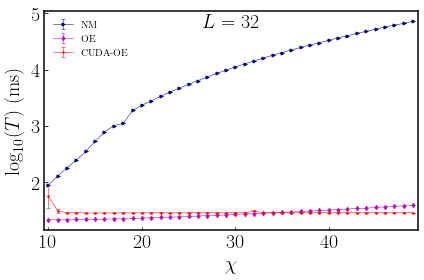

In [2]:
csv_file =  open ('lattice32_nm_oe_cpoe.csv', mode='r')
reader = csv.DictReader(csv_file)
chi_list = []
time_nm = []
time_oe = []
time_cpoe = []
err_nm = []
err_oe = []
err_cpoe = []
for row in reader:
    chi_list.append (int (row['chi']))
    time_nm.append (float (row['time_nm']))
    time_oe.append (float (row['time_oe']))
    time_cpoe.append (float (row['time_cpoe']))
    err_nm.append (float (row['err_nm']))
    err_oe.append (float (row['err_oe']))
    err_cpoe.append (float (row['err_cpoe']))

logerr_nm = []
logerr_oe = []
logerr_cpoe = []   
length = len (time_nm)
for i in range (length):
    logerr_nm.append (0.434*err_nm[i] / time_nm[i])
    logerr_oe.append (0.434*err_oe[i] / time_oe[i])
    logerr_cpoe.append (0.434*err_cpoe[i] / time_cpoe[i])




fig_simple = plt.figure (figsize=(6, 4))
mpl.rcParams['axes.linewidth'] = 1.5
fsize = 20
msize = 3.0
plt.rc ('text', usetex=True)
plt.rc ('font', family='serif')

ax0 = fig_simple.add_subplot (111)
ax0.set_title (r'$L=32$', x=0.5, y=0.9, fontsize=fsize)
ax0.set_xlim (9.5, 49.5)
ax0.errorbar (chi_list, np.log10 (time_nm), yerr=logerr_nm, 
              color='navy', linewidth=0.5, marker='>', capsize=2, capthick=0.5, markersize=msize, label='NM')
ax0.errorbar (chi_list, np.log10 (time_oe), yerr=logerr_oe,
              color='m', linewidth=0.5, marker='d', capsize=2, capthick=0.5, markersize=msize, label='OE')
ax0.errorbar (chi_list, np.log10 (time_cpoe), yerr=logerr_cpoe,
              color='red', linewidth=0.5, marker='.', capsize=2, capthick=0.5, markersize=msize, label='CUDA-OE')
ax0.tick_params (axis='both', labelsize=fsize, direction='in')
ax0.set_xlabel ('$\chi$', fontsize=fsize)
# ax0.axes.get_xaxis().set_visible(False)
ax0.set_ylabel ('$\log_{10} (T)$ (ms)', fontsize=fsize)
ax0.legend (fontsize=10, frameon=False, loc='upper left')

fig_simple.tight_layout ()
fig_simple.savefig ('time_nm_oe.pdf', format='PDF')



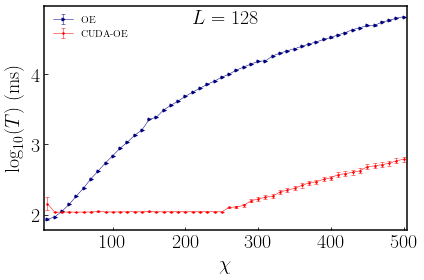

In [3]:
csv_file =  open ('lattice128_oe_cpoe.csv', mode='r')
reader = csv.DictReader(csv_file)
chi_list = []
time_oe = []
time_cpoe = []
err_oe = []
err_cpoe = []
for row in reader:
    chi_list.append (int (row['chi']))
    time_oe.append (float (row['time_oe']))
    time_cpoe.append (float (row['time_cpoe']))
    err_oe.append (float (row['err_oe']))
    err_cpoe.append (float (row['err_cpoe']))

logerr_oe = []
logerr_cpoe = []   
length = len (time_oe)
for i in range (length):
    logerr_oe.append (0.434*err_oe[i] / time_oe[i])
    logerr_cpoe.append (0.434*err_cpoe[i] / time_cpoe[i])

fig_cuda = plt.figure (figsize=(6, 4))
mpl.rcParams['axes.linewidth'] = 1.5
fsize = 20
msize = 3.0
plt.rc ('text', usetex=True)
plt.rc ('font', family='serif')

ax0 = fig_cuda.add_subplot (111)
ax0.set_title (r'$L=128$', x=0.5, y=0.9, fontsize=fsize)
ax0.set_xlim (5, 505)
ax0.errorbar (chi_list, np.log10 (time_oe), yerr=logerr_oe,
              color='navy', linewidth=0.5, marker='>', capsize=2, capthick=0.5, markersize=msize, label='OE')
ax0.errorbar (chi_list, np.log10 (time_cpoe), yerr=logerr_cpoe,
              color='red', linewidth=0.5, marker='.', capsize=2, capthick=0.5, markersize=msize, label='CUDA-OE')
ax0.tick_params (axis='both', labelsize=fsize, direction='in')
ax0.tick_params (axis='both', labelsize=fsize, direction='in')
ax0.set_xlabel ('$\chi$', fontsize=fsize)
# ax0.axes.get_xaxis().set_visible(False)
ax0.set_ylabel ('$\log_{10} (T)$ (ms)', fontsize=fsize)
ax0.legend (fontsize=10, frameon=False, loc='upper left')

fig_cuda.tight_layout ()
fig_cuda.savefig ('time_cuda.pdf', format='PDF')


